In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping
import os
import random
import tensorflow as tf
from sklearn.svm import OneClassSVM

os.environ['PYTHONHASHSEED'] = str(100)
random.seed(100)
np.random.seed(100)

tf.random.set_seed(100)

import matplotlib.pyplot as plt


In [2]:
#ata_main.csv содержит уже вычисленные 4 метрики WR tg apdex erore
DATA = pd.read_csv('data_main.csv')
DATA['point'] = pd.to_datetime(DATA['point'])
DATA.set_index('point', inplace= True)

data = DATA.copy()

In [3]:
data.head()

,WR,tg,apdex,erore
point,,,,
2024-04-15 23:32:00,0.007722,3898.0,0.999679,0.000128
2024-04-15 23:33:00,0.008363,3917.5,0.999745,0.000128
2024-04-15 23:34:00,0.008709,3993.0,0.999687,0.000000
2024-04-15 23:35:00,0.008286,3991.5,0.999812,0.000000
2024-04-15 23:36:00,0.010874,3915.5,0.999489,0.000000


In [4]:
time = (data.index)
print(f"Минимальная дата в данных: {min(time)}")
print(f"Максимальная дата в данных: {max(time)}")

first_index = min(time)
last_index = max(time)

Минимальная дата в данных: 2024-04-15 23:32:00
Максимальная дата в данных: 2024-05-16 00:58:00


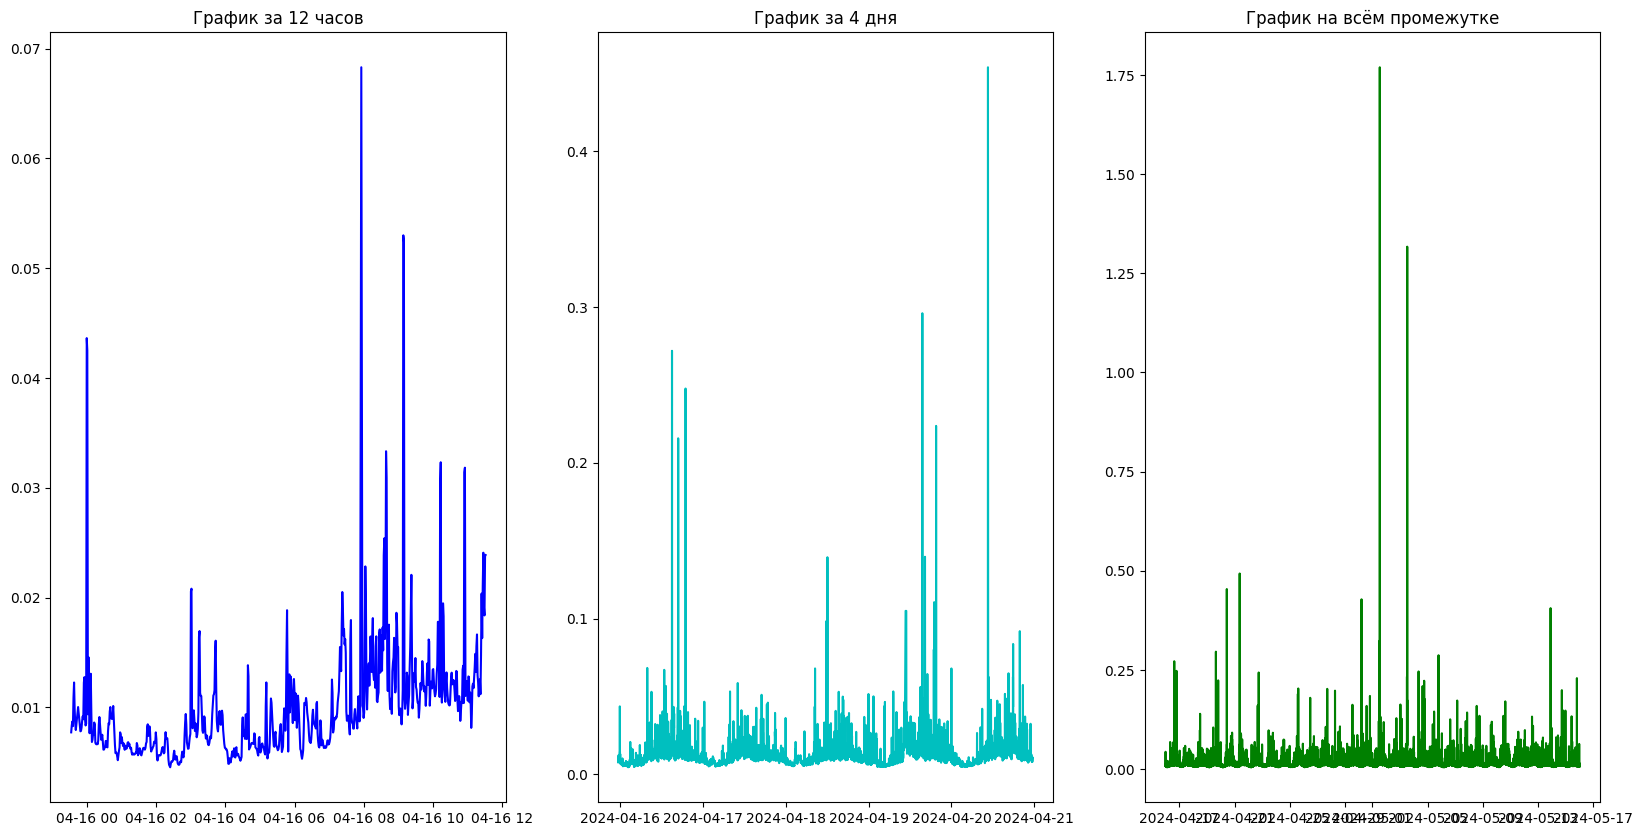

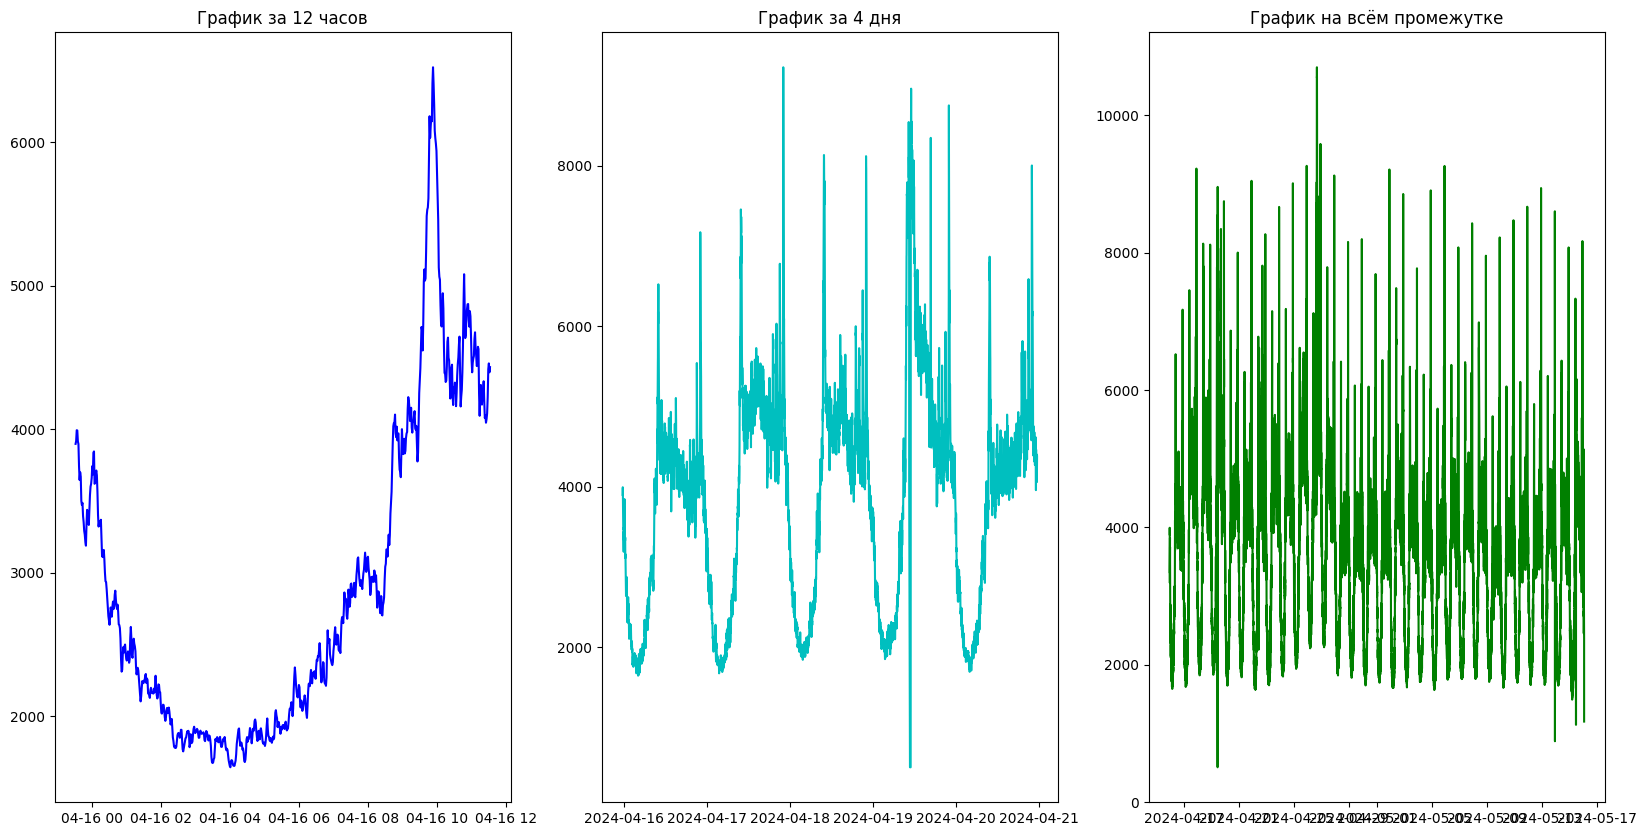

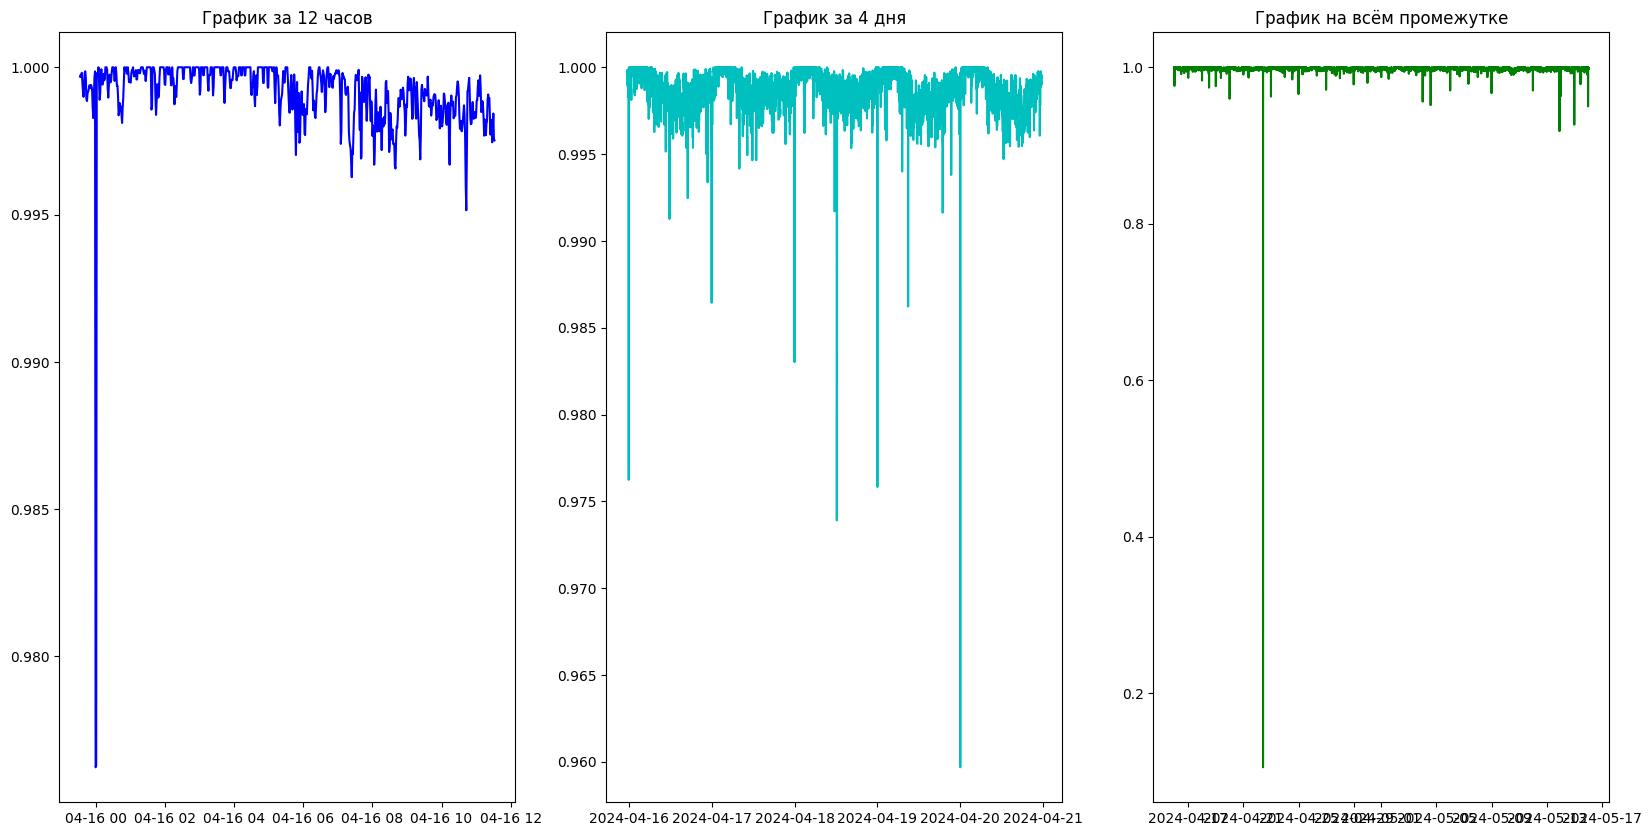

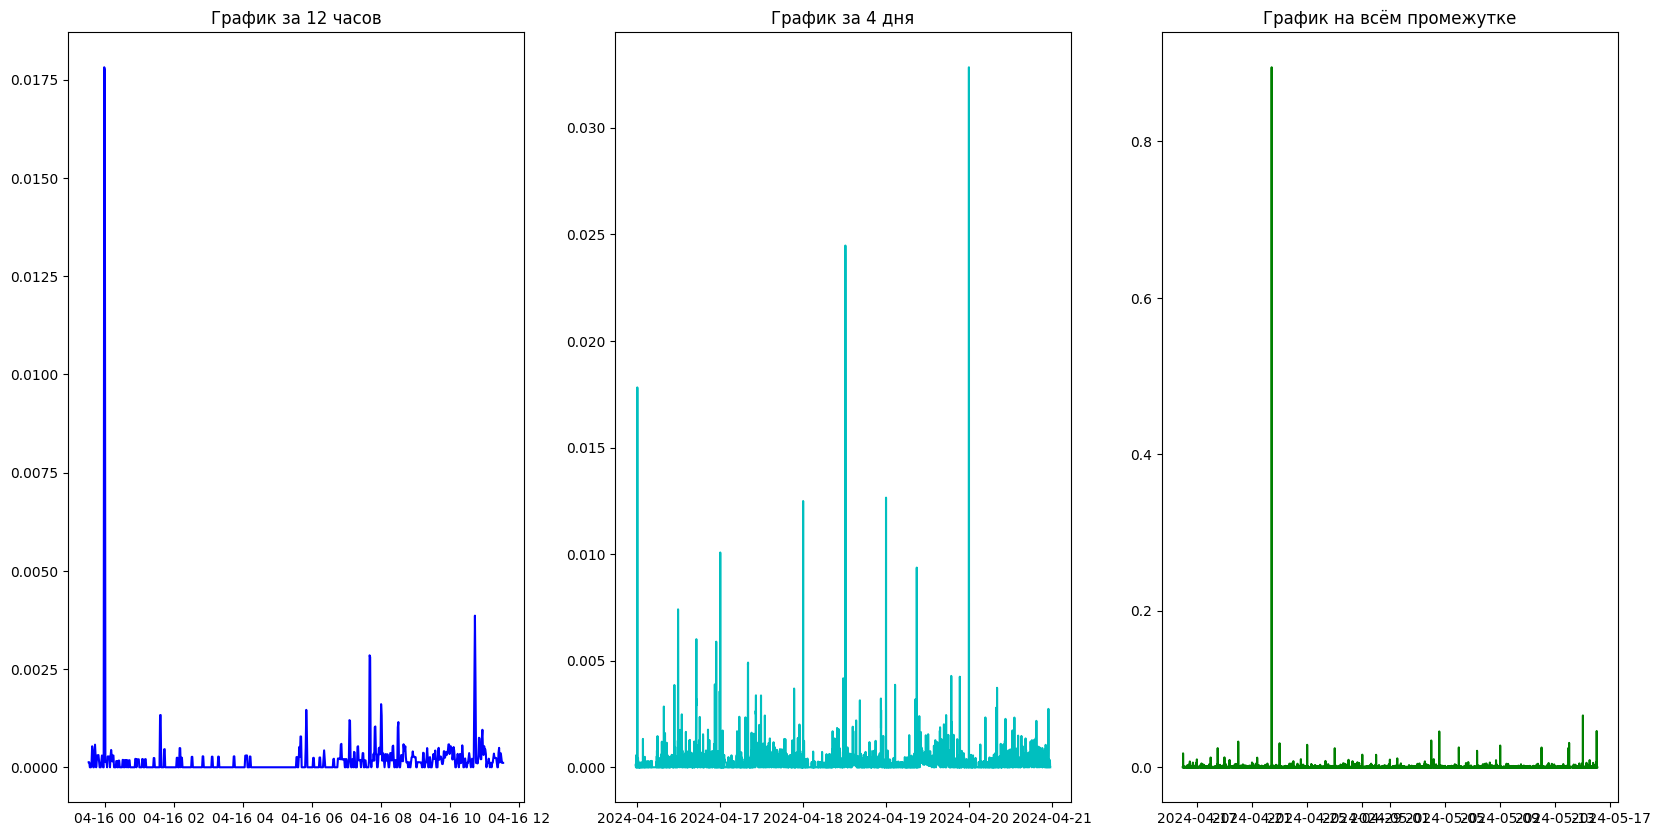

In [5]:
data_plot = ['2024-04-16 11:32:00', '2024-04-20 23:32:00']

for col in data.columns:
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    axes[0].plot(data[col].loc[:data_plot[0]], color='b')
    axes[0].set_title('График за 12 часов')
    # Нарисовать второй график
    axes[1].plot(data[col].loc[:data_plot[1]], color='c')
    axes[1].set_title('График за 4 дня')
    # Нарисовать третий график
    axes[2].plot(data[col], color='g')
    axes[2].set_title('График на всём промежутке')
    plt.show()

<Axes: >

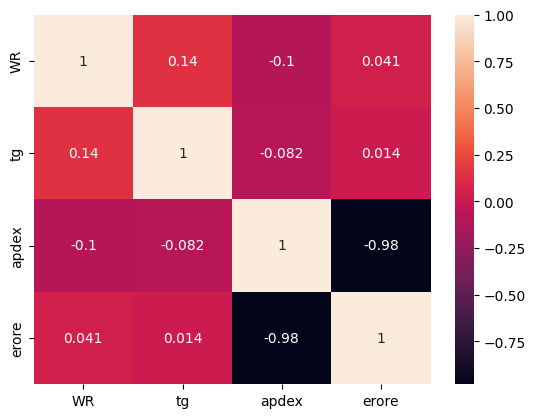

In [6]:
sns.heatmap(data.corr(), annot= True)

In [7]:
data.drop('erore', axis = 1, inplace = True)
DATA.drop('erore', axis = 1, inplace = True)

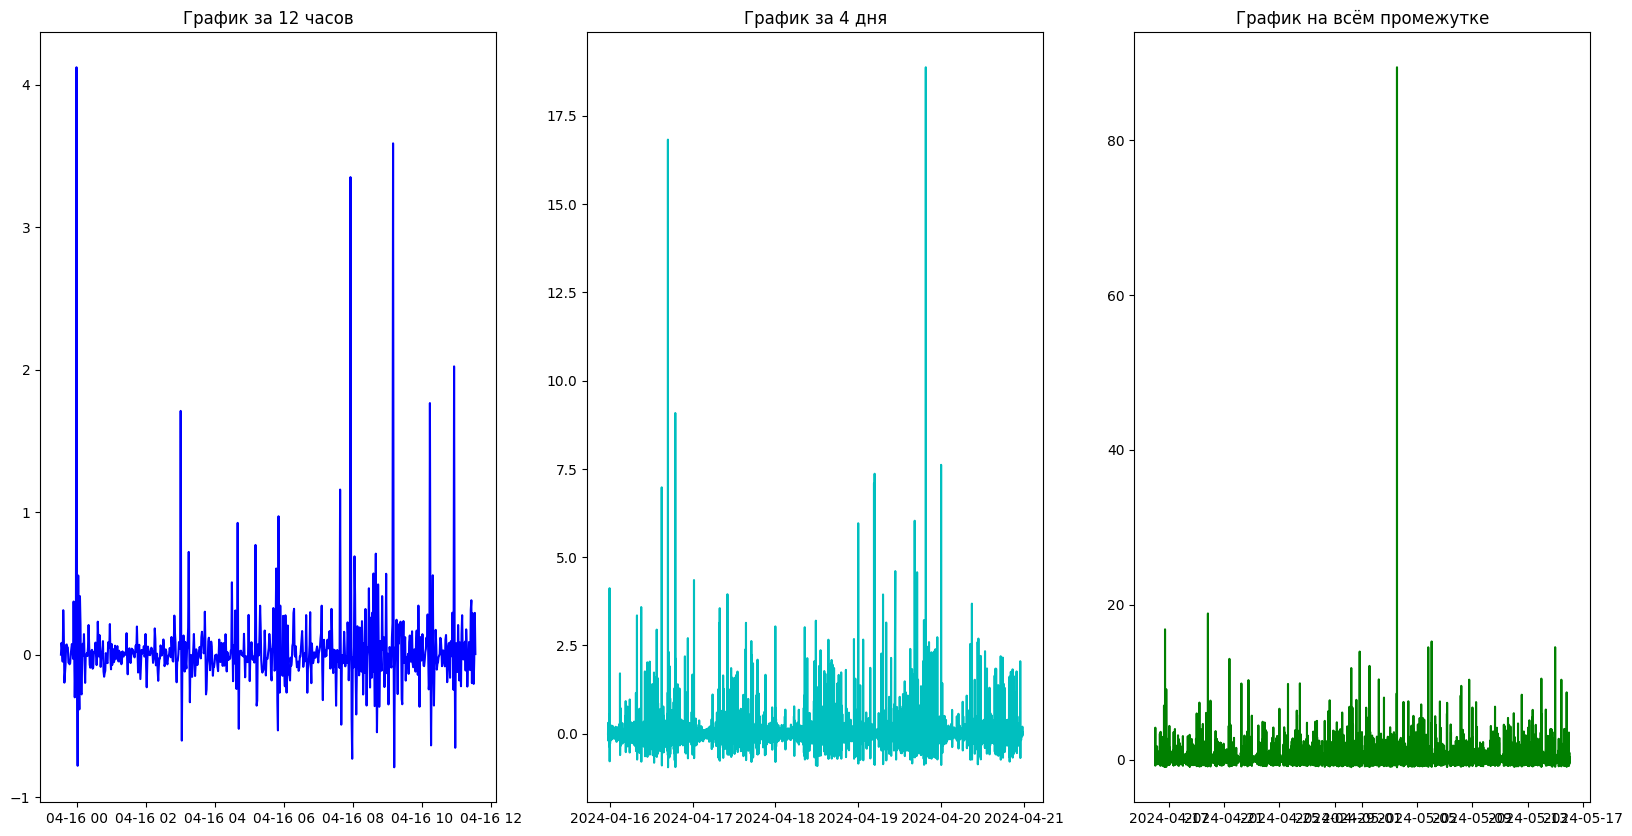

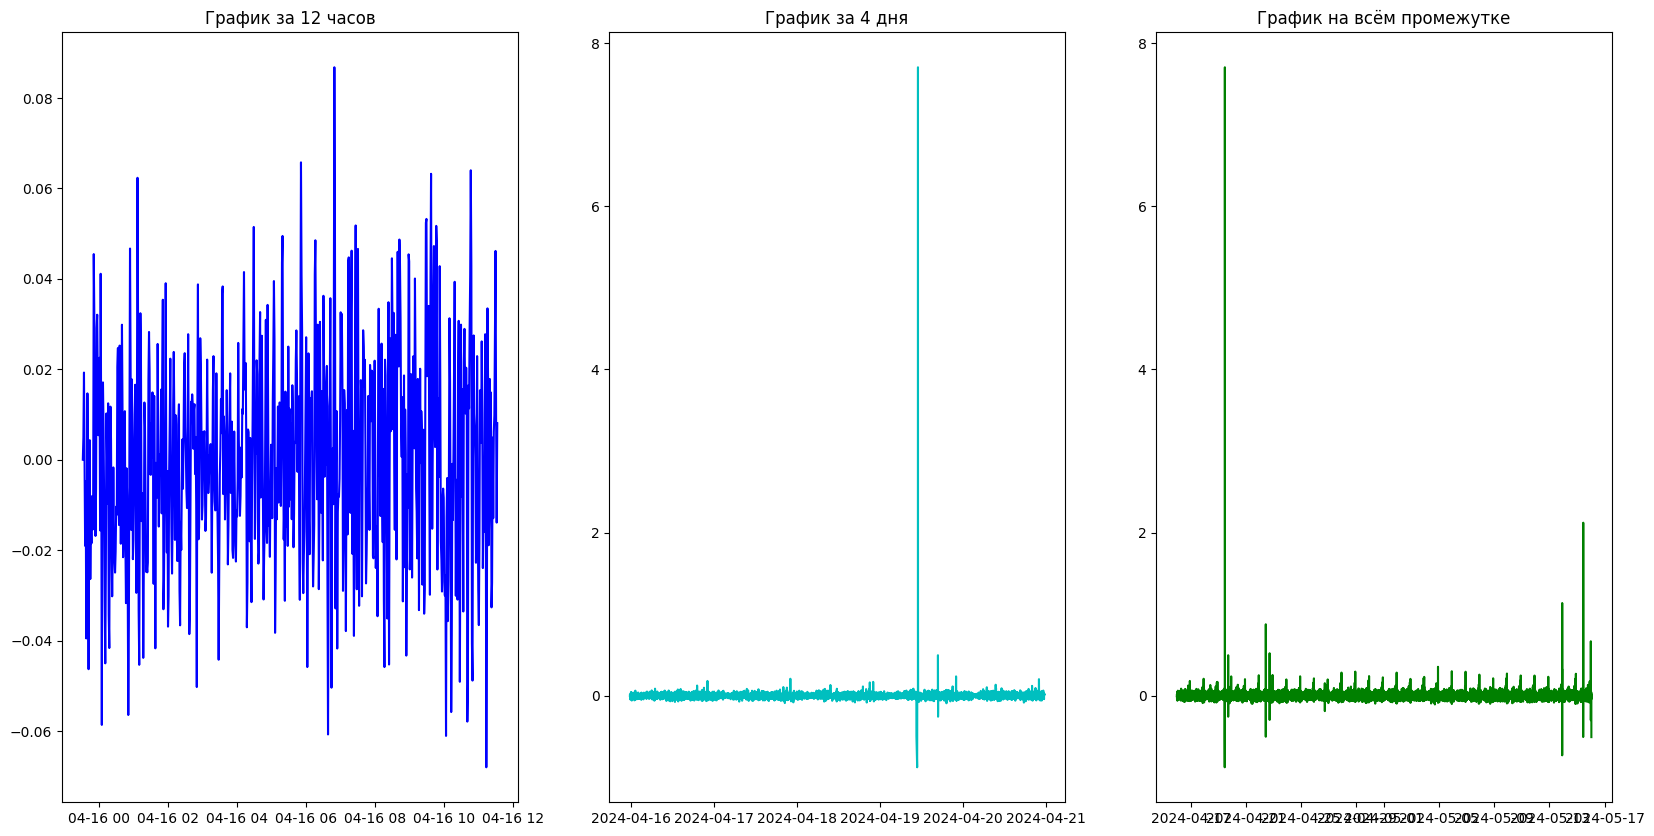

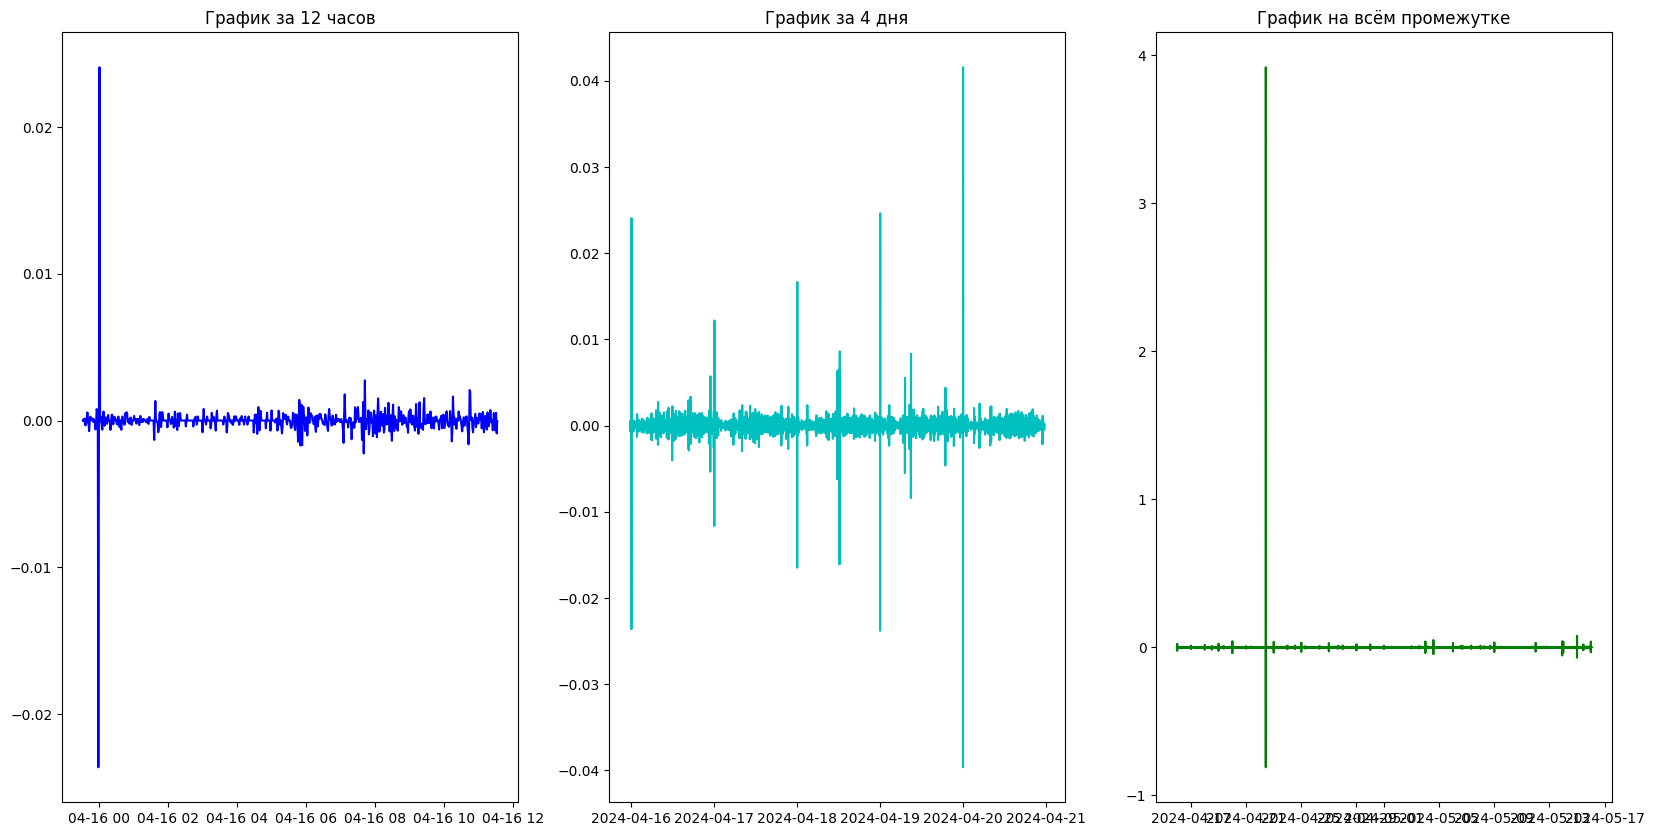

In [8]:
data['delta_wr'] = data['WR'].pct_change() 
data['delta_tg'] = data['tg'].pct_change()
data['delta_apdex'] = data['apdex'].pct_change() 
data.fillna(0, inplace=True)

data_plot = ['2024-04-16 11:32:00', '2024-04-20 23:32:00']

for col in ['delta_wr', 'delta_tg', 'delta_apdex']:
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    axes[0].plot(data[col].loc[:data_plot[0]], color='b')
    axes[0].set_title('График за 12 часов')
  
    axes[1].plot(data[col].loc[:data_plot[1]], color='c')
    axes[1].set_title('График за 4 дня')

    axes[2].plot(data[col], color='g')
    axes[2].set_title('График на всём промежутке')
    plt.show()

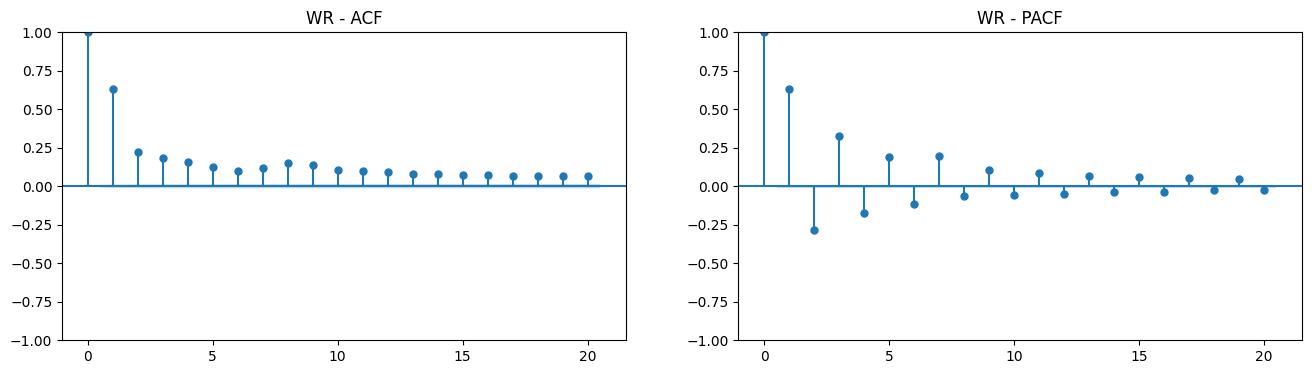

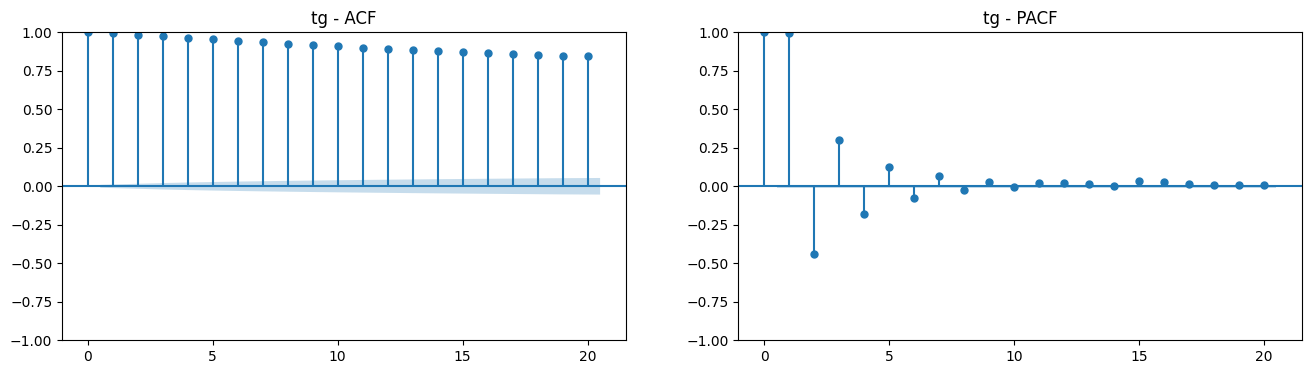

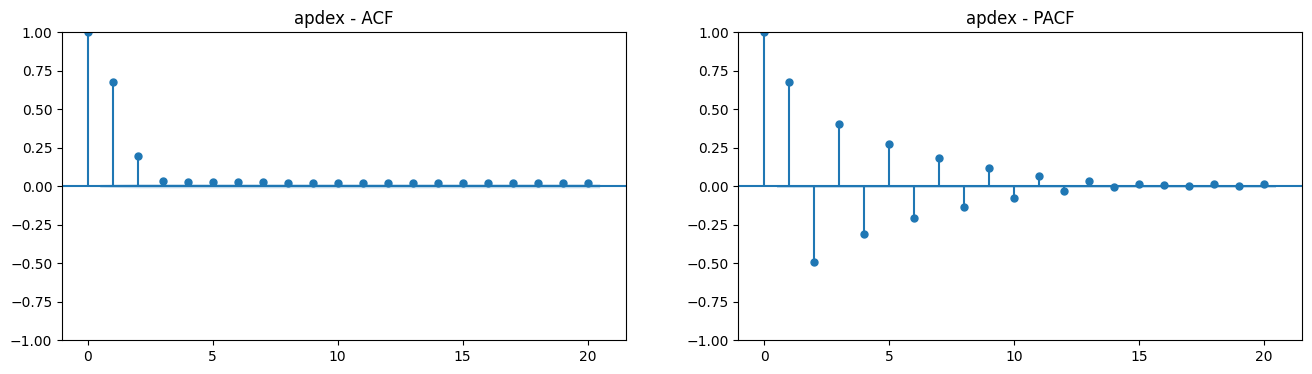

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Построение ACF и PACF для каждого временного ряда
for col in DATA.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    plot_acf(data[col], lags=20, ax=axes[0])
    plot_pacf(data[col], lags=20, ax=axes[1])
    axes[0].set_title(f'{col} - ACF')
    axes[1].set_title(f'{col} - PACF')
    plt.show()

In [10]:
# ADF тест
import statsmodels.tsa.api as tsa

for col in data.columns[:3]:
    adf_result = tsa.adfuller(data[col])
    print(f'ADF Test: {col}')
    print(f'Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    for key, value in adf_result[4].items():
        print(f'Critial Values {key}, {value}')
    print()

ADF Test: WR
Statistic: -18.989947334957623
p-value: 0.0
Critial Values 1%, -3.4305013256308654
Critial Values 5%, -2.8616068825896526
Critial Values 10%, -2.566805599430745

ADF Test: tg
Statistic: -6.111077561356999
p-value: 9.329759972100031e-08
Critial Values 1%, -3.430501322129127
Critial Values 5%, -2.861606881042001
Critial Values 10%, -2.5668055986069733

ADF Test: apdex
Statistic: -30.825504085761533
p-value: 0.0
Critial Values 1%, -3.4305012451318677
Critial Values 5%, -2.861606847011778
Critial Values 10%, -2.56680558049364



> Исходя из графиков и теста Дики-Фуллера можем сделать выводы что: 
> * Wr - стацианарный, без тренда, не сезонный, есть автокорреляция в начале
> * tg - не стацианарный, без тренда, сезонный (имеет вид синусойды), имеет сильную автокорреляцию
> * apdex - стацианарный, без тренда, не сезонный, пристуствует шум,  есть автокорреляция в начале

In [11]:
#Дифференцирование временного ряда
data['tg'] = data['tg'].diff().dropna().replace([np.inf, -np.inf], np.nan).dropna()

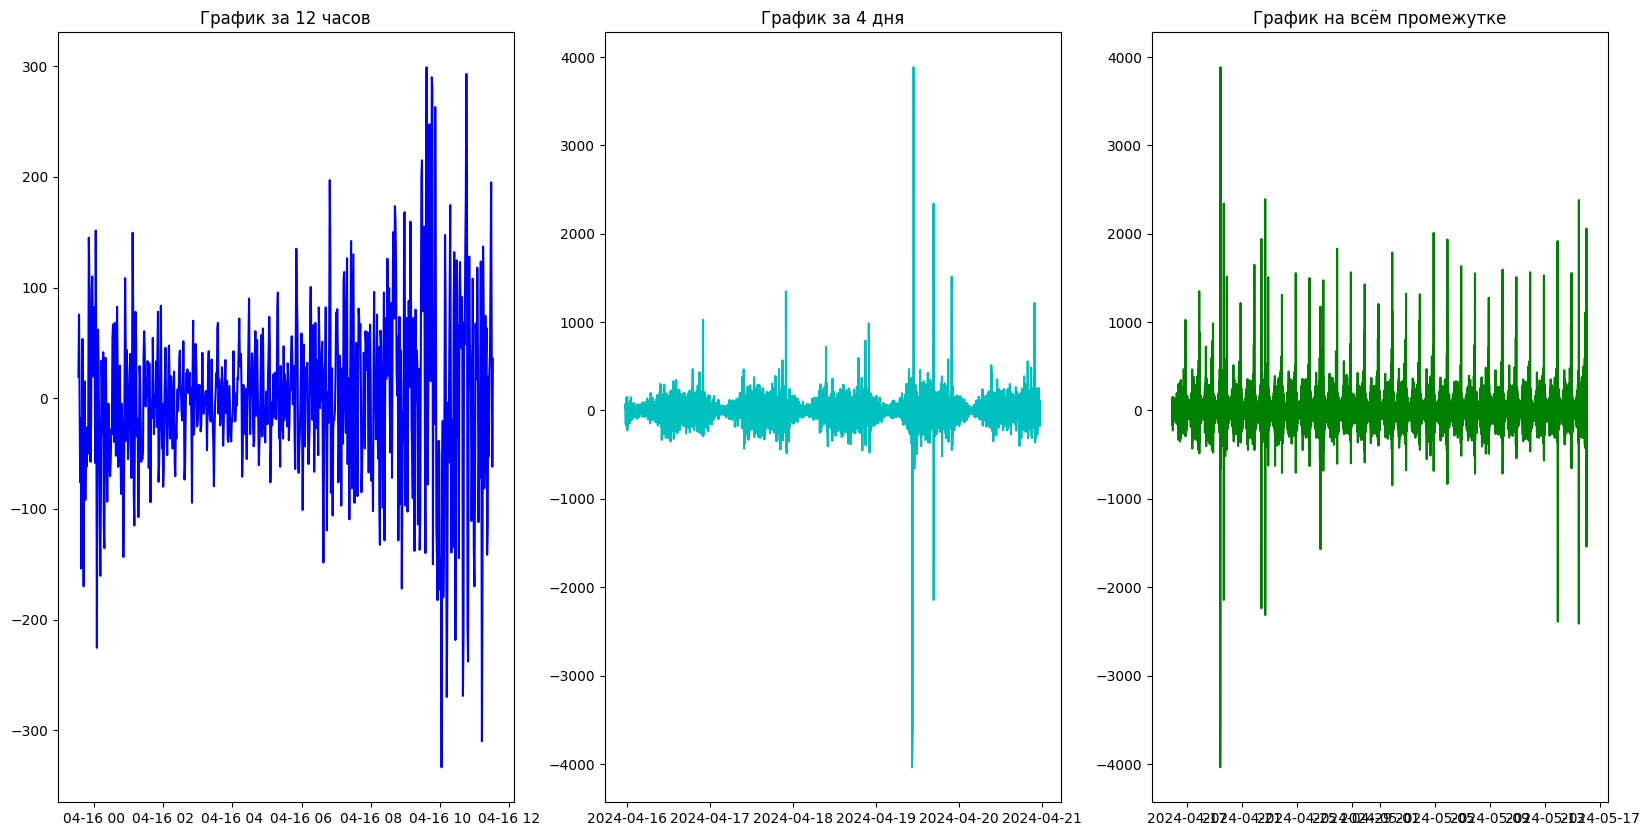

In [12]:

#костыль №1
for col in ['tg']:
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    axes[0].plot(data[col].loc[:data_plot[0]], color='b')
    axes[0].set_title('График за 12 часов')
    
    
    axes[1].plot(data[col].loc[:data_plot[1]], color='c')
    axes[1].set_title('График за 4 дня')
  

    axes[2].plot(data[col], color='g')
    axes[2].set_title('График на всём промежутке')
    plt.show()

In [13]:
first_10_columns = data['WR'].head(10)
window_size = 3  # Размер окна для скользящего среднего
data['WR'] = data['WR'].rolling(window=window_size).mean()
data['WR'][:10] = first_10_columns

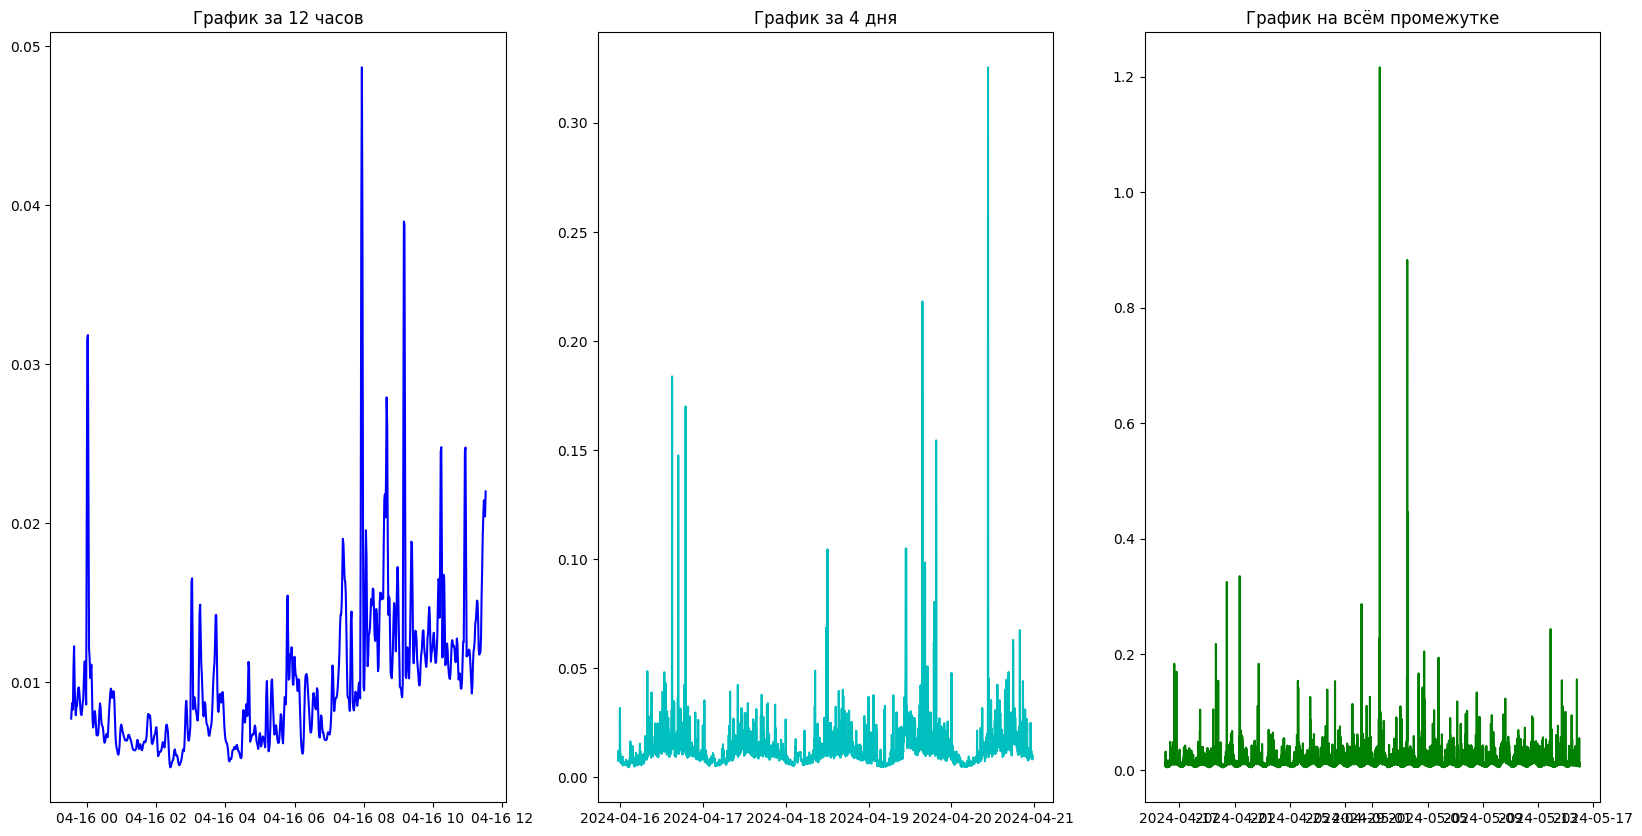

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].plot(data['WR'].loc[:data_plot[0]], color='b')
axes[0].set_title('График за 12 часов')


axes[1].plot(data['WR'].loc[:data_plot[1]], color='c')
axes[1].set_title('График за 4 дня')


axes[2].plot(data['WR'], color='g')
axes[2].set_title('График на всём промежутке')
plt.show()

> Сравнивать мы будем 3 модели, а именно: IForest, DBScan в Автоэнкодер

In [15]:
def Auoto(param, data):
    input_dots = Input((6,))

    x = Dense(param[0], kernel_regularizer=regularizers.l2(param[4]))(input_dots)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(param[5])(x)
    
    bottleneck = Dense(param[1], activation='linear')(x)

    x = Dense(param[0], kernel_regularizer=regularizers.l2(param[4]))(input_dots)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(param[5])(x)
    
    out = Dense(6, activation='linear')(x)

    model = Model(input_dots, out)
    model.compile(optimizer=Adam(param[2]), loss='mae', metrics=["mse"])
    

    model.fit(data, data,
                validation_split=0.2,
                epochs=10,
                batch_size=param[3],
                verbose=0,
                shuffle=True,

               )
    return model


def anom_for_aoutoencoder(model, data, index):
    
    delta_value = data - model.predict(data)
    limit = pd.DataFrame(delta_value).abs().sum(axis=1).quantile(0.98)
    
    data_delta =  pd.DataFrame(delta_value, index=index).abs().sum(axis=1)
    data_delta.head()
    data_is_anomaly = data_delta.apply(lambda x: 1 if x>limit else 0)

    return data_is_anomaly, limit


In [16]:

iforest = IsolationForest(contamination=0.02,random_state=42)
svm = OneClassSVM()

>*сначала обучим на данных, которые мы не сглаживали и не дифференцировали

In [17]:
data = DATA.copy()
data['delta_wr'] = data['WR'].pct_change() 
data['delta_tg'] = data['tg'].pct_change()
data['delta_apdex'] = data['apdex'].pct_change() 
data.fillna(0, inplace=True)

In [18]:
#великолепный код ON
train, test, _, __ = train_test_split(data, data, train_size=0.7, shuffle=False)
valid, test, _, __ = train_test_split(test, test, train_size=0.5, shuffle=False)
#великолепный код OFF

StSc = StandardScaler().fit(train)
train = StSc.transform(train)
valid = StSc.transform(valid)
test = StSc.transform(test)
data_sc = StSc.transform(data)

In [19]:
pred_forest = iforest.fit(train).predict(data_sc)
pred_forest = np.where(pred_forest == -1, 1, 0)
pred_forest = pd.Series(pred_forest, index = DATA.index)


In [20]:
svm.fit(train)
pred_svm = svm.predict(data_sc)
pred_svm = pd.Series(pred_svm, index = DATA.index)

>* На этом этапе мы решили отказаться от будущего взаимодействия с OneClassSVM, ввиду слишком маленькой скорости предсказания, что не позволительно в данной задаче. Мы подозревали что так будет, так как One-Class SVM сам по себе дорогой, но не думали что настолько плохо 

In [21]:
model = Auoto([5,4, 0.02, 10, 0.1, 0], data=train)
pred_anom_for_aoutoencoder, limit = anom_for_aoutoencoder(model, data_sc, DATA.index)

1353/1353 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step


In [22]:
def plot_anom(anomalies, start='2024-04-18 23:00:00', end='2024-04-19 23:00:00', name = None):

    data_slice = data.loc[start:end]
    predict_data_slice = anomalies.loc[start:end]
    print(sum(predict_data_slice))

    fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharex=True)
    fig.suptitle(f'Графики по {name}')
    for i,col in zip(range(3), DATA.columns):
        axes[i].set_title(f'График по метрике: {col}', fontsize=16)
        data_slice[col].plot(ax=axes[i], style='b-')
        for index, value in zip(predict_data_slice.index, predict_data_slice):
            if value == 1:
                axes[i].axvspan(index, index, color='red', alpha=0.7)
    plt.show()

56


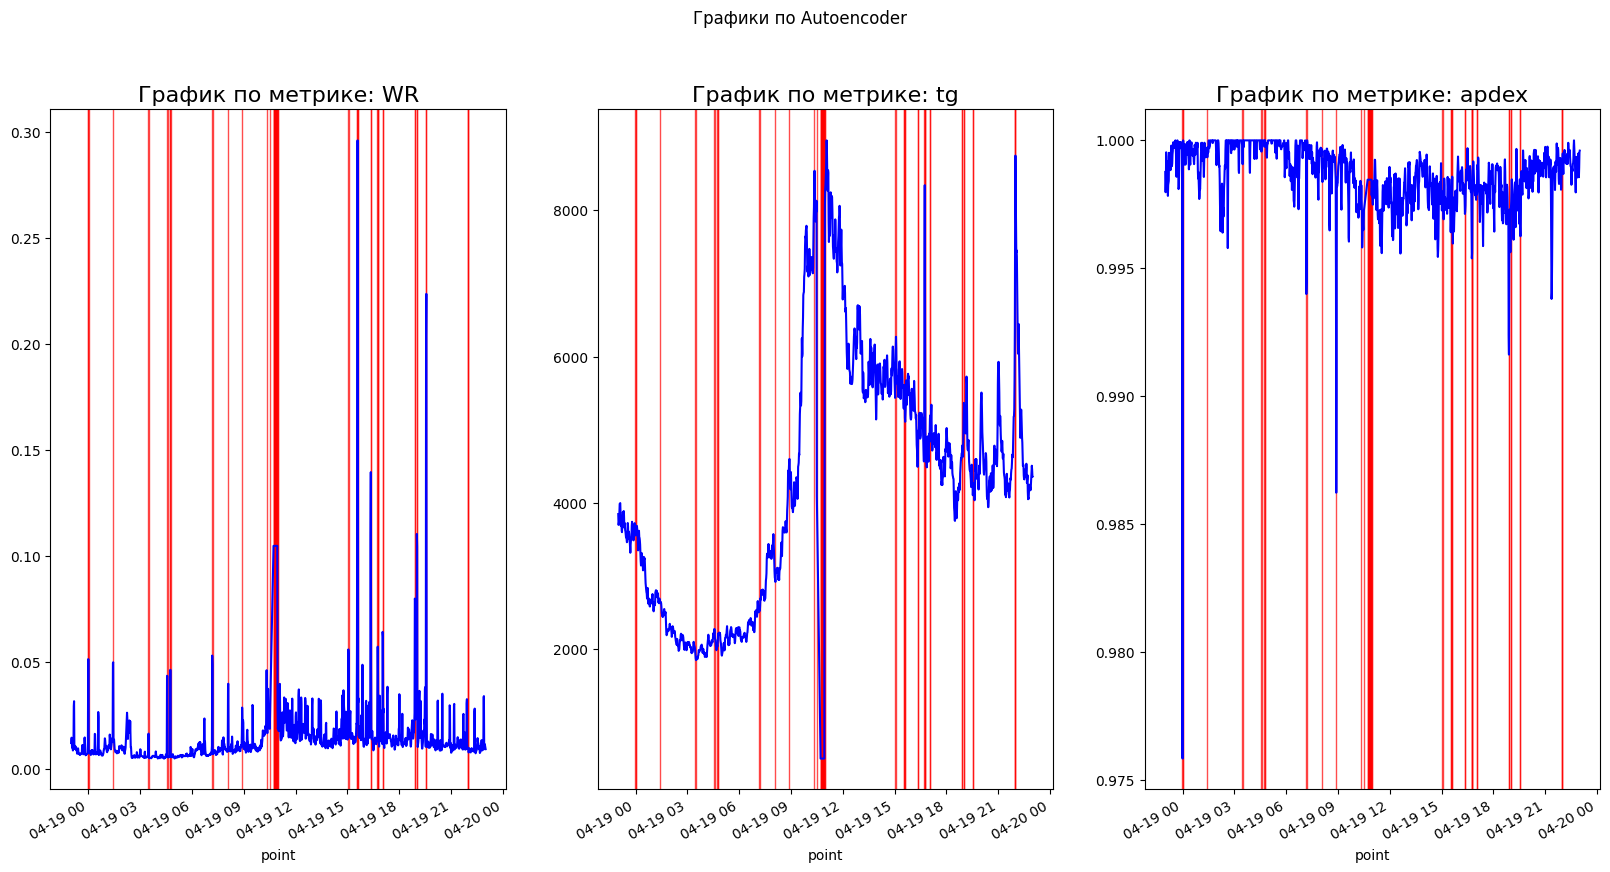

In [23]:
plot_anom(pred_anom_for_aoutoencoder, name='Autoencoder')

53


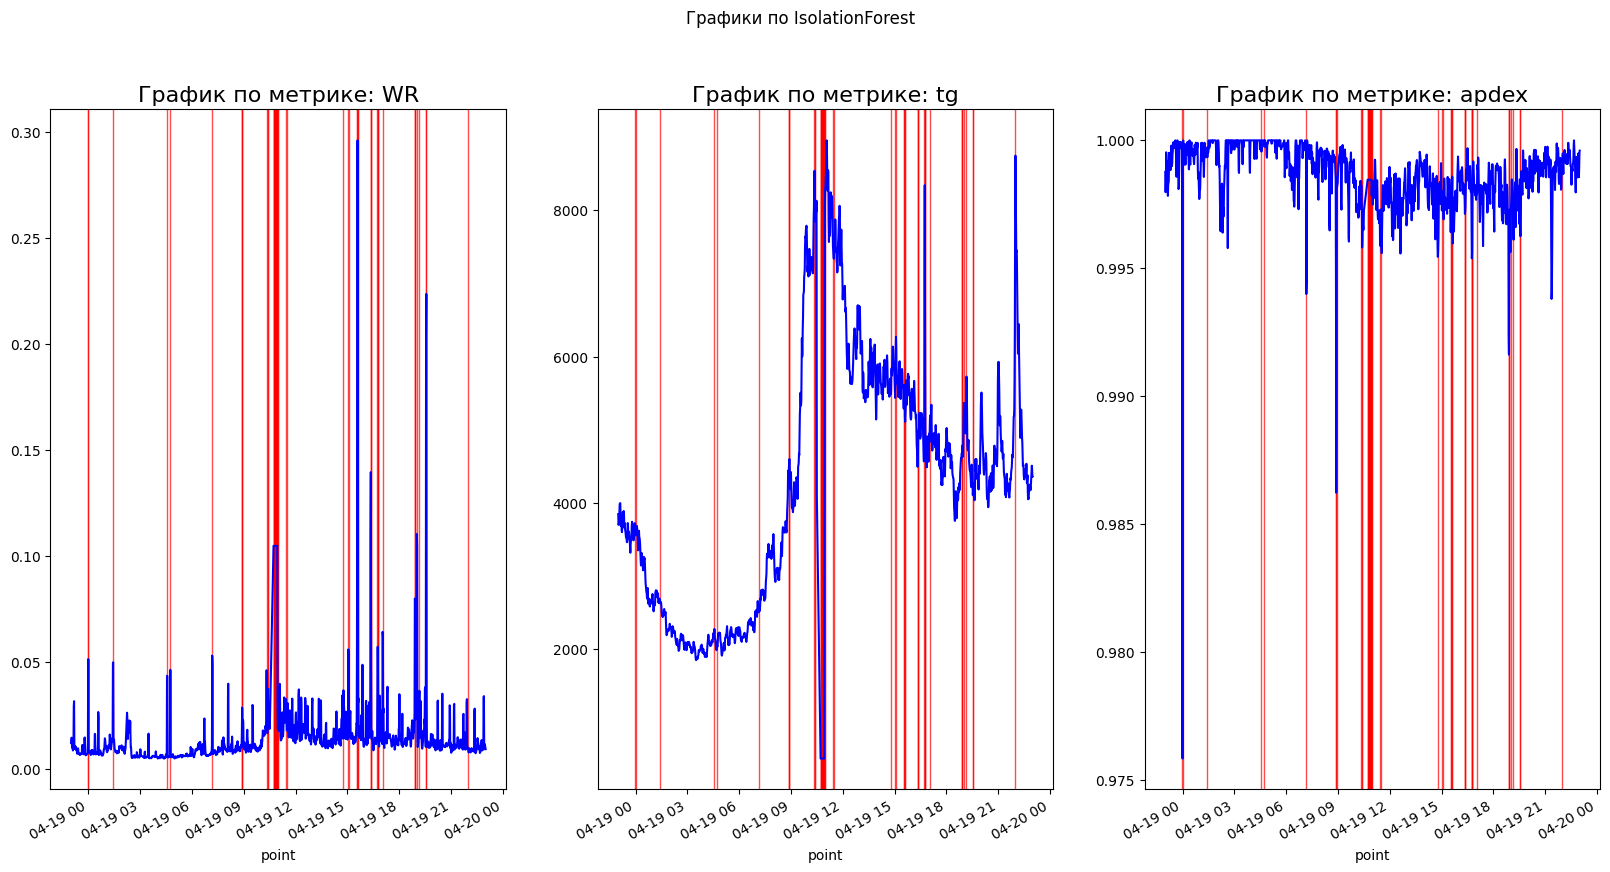

In [24]:
plot_anom(pred_forest, name='IsolationForest')

>* на данном этапе мы пока склоняемся к использованию Автоэнкодера, но это не было использовано подбора гиперпараметров и изменения данных

In [25]:
data = DATA.copy()
data['delta_wr'] = data['WR'].pct_change() 
data['delta_tg'] = data['tg'].pct_change()
data['delta_apdex'] = data['apdex'].pct_change() 
data.fillna(0, inplace=True)

#великолепный код ON
train, valid, _, __ = train_test_split(data, data, train_size=0.7, shuffle=False)
#великолепный код OFF

StSc = StandardScaler().fit(train)
train = StSc.transform(train)
valid = StSc.transform(valid)
data_sc = StSc.transform(data)



In [26]:
#сглаживание
first_10_columns = data['WR'].head(10)
window_size = 3  
data['WR'] = data['WR'].rolling(window=window_size).mean()
data['WR'][:10] = first_10_columns

In [27]:
#убираем сезонность в tg
data['tg'] = data['tg'].diff().dropna().replace([np.inf, -np.inf], np.nan).dropna()

In [28]:
iforest = IsolationForest(random_state=42, contamination=0.02)
pred_forest = iforest.fit(train).predict(data_sc)
pred_forest = np.where(pred_forest == -1, 1, 0)
pred_forest = pd.Series(pred_forest, index = DATA.index)

53


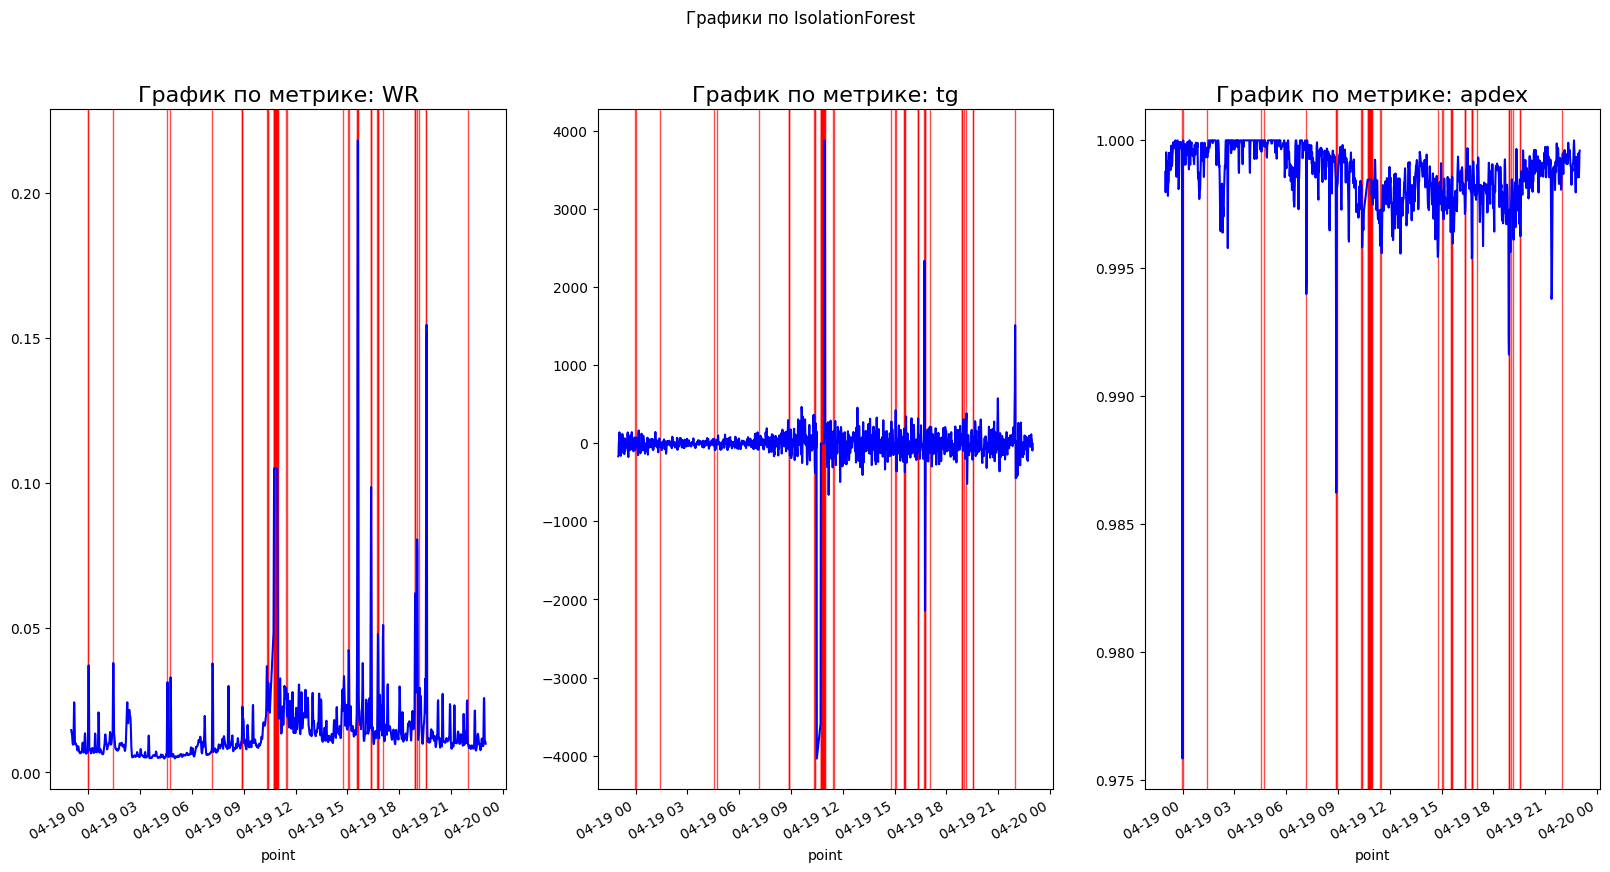

In [29]:
plot_anom(pred_forest, name='IsolationForest')

1353/1353 ━━━━━━━━━━━━━━━━━━━━ 1s 523us/step
59


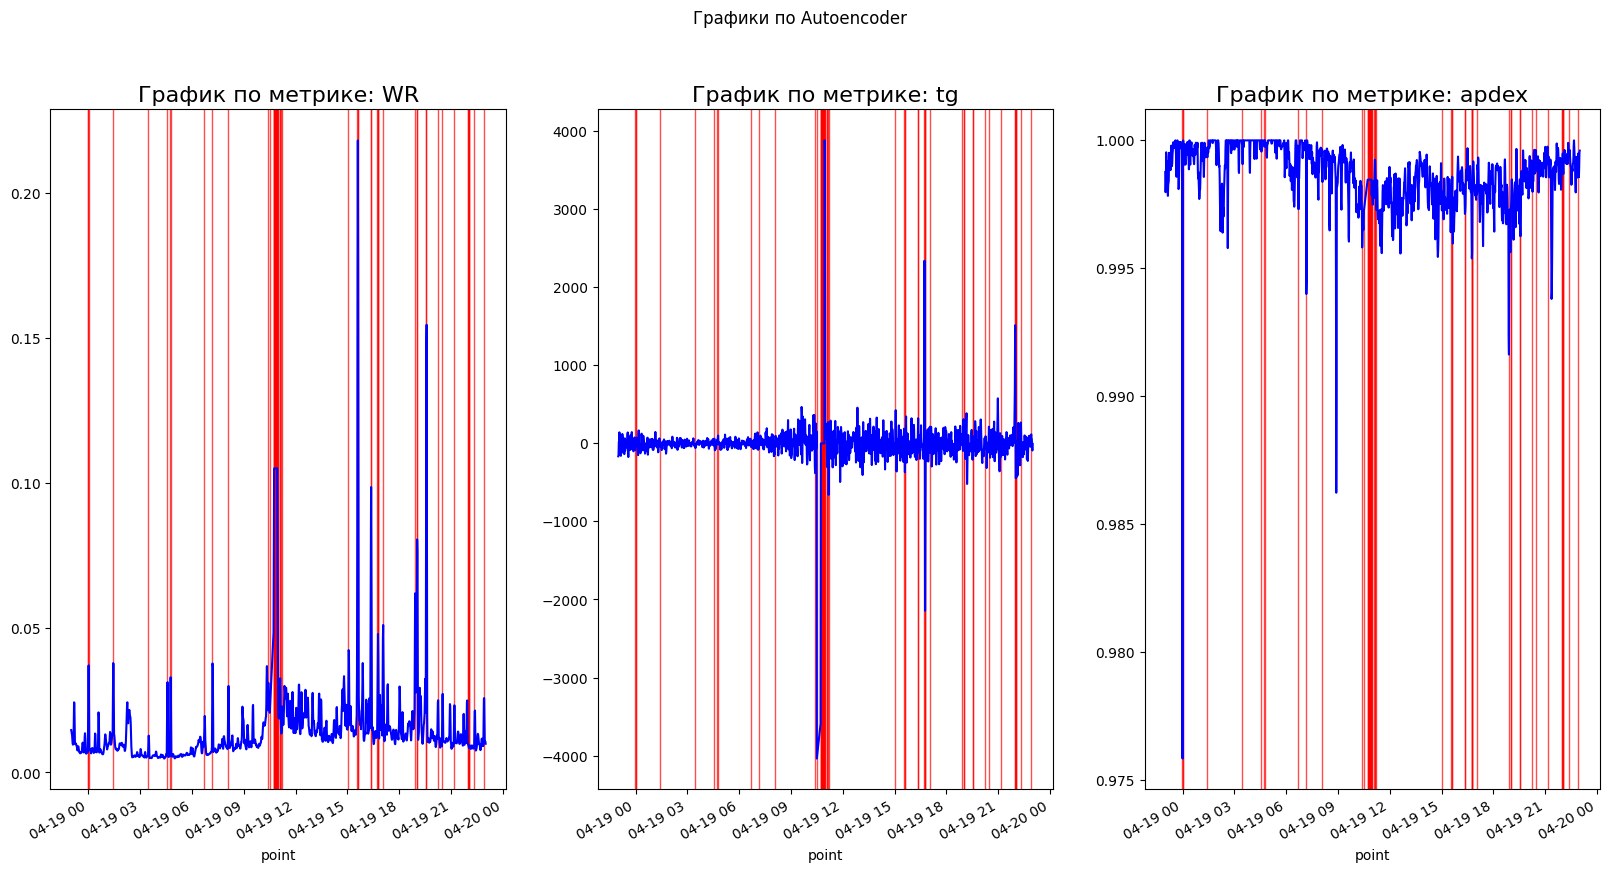

In [30]:
model = Auoto([5,4, 0.02, 10, 0.1, 0], data=train)
pred_anom_for_aoutoencoder, limit = anom_for_aoutoencoder(model, data_sc, DATA.index)
plot_anom(pred_anom_for_aoutoencoder, name='Autoencoder')

>* После выполнения операций дифференцирования  и сглаживание мы улучшили результаты для предсказний, займёмся минимизацией метрик.

In [31]:
%%script false --no-raise-error
#подбор лучших параметров посредством понижение метрики MAE

n1 = [5,4]
n2 = [4,3]
learn_rate = np.linspace(1e-2,1e-1, 2)
banch = np.linspace(10, 50, 3).astype(int)
l2 = np.linspace(0.1,0.9,4)
dropout = np.linspace(0,0.9, 3)

combinations = list(itertools.product(n1, n2, learn_rate, banch, l2, dropout))
combinations = [combo for combo in combinations if combo[0] > combo[1]]

print(f'Количество комбинаций: {len(combinations)}')

errors = {}
for params in combinations:
    
    model = Auoto(params, train)
    train_pred = model.predict(train, batch_size=params[3])
    val_pred = model.predict(valid, batch_size=params[3])
    
    train_MAE = mean_absolute_error(train, train_pred)
    val_MAE = mean_absolute_error(valid, val_pred)
    
    errors[params] = [train_MAE, val_MAE]


sorted_params = sorted(errors.items(), key=lambda x: x[1][1])  
best_params = sorted_params[0][0]  
print("Лучший набор параметров:", best_params)"""

#[4,3, 0.01, 10, 0.1, 0]

Couldn't find program: 'false'


In [32]:
model = Auoto([4,3, 0.01, 10, 0.1, 0], data=train)
pred_anom_for_aoutoencoder, limit = anom_for_aoutoencoder(model, data_sc, DATA.index)

1353/1353 ━━━━━━━━━━━━━━━━━━━━ 1s 522us/step


In [34]:
pred_data = model.predict(test)
print(f"MAPE ннашей модели: {mean_absolute_percentage_error(test, pred_data):.2f}%")

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
MAPE ннашей модели: 4.88%


по итогам нами была выбрана модель отснованная на рекурентных сетях, которая хорошо преобразовывает данные, вследвии чего мы выевляем как точенчные, так и коллективные аномалии